## Vision Project Walkthrough

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import pandas as pd
#imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

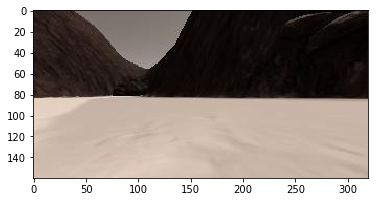

In [2]:
path = 'test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

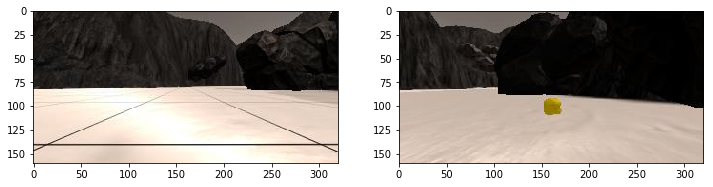

In [3]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = "calibration_images/example_grid1.jpg"
example_rock = "calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

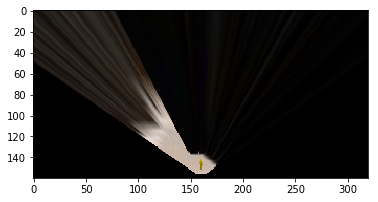

In [277]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    #  image in biv with mask
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    # mask for obstacle to be the same as navigable terrain
    ones = np.ones((img.shape[1], img.shape[0]))
    mask = cv2.warpPerspective(ones, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped, mask

dst = 5
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])


warped,mask = perspect_transform(rock_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

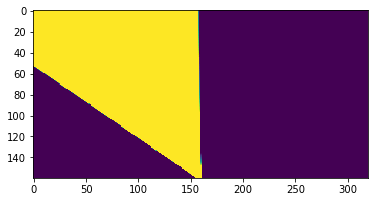

In [178]:
plt.imshow(mask)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

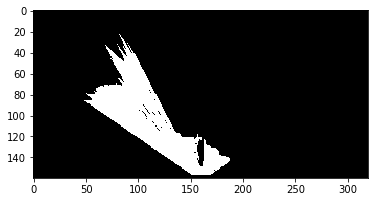

In [5]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, min_rgb_thresh=(160, 160, 160),max_rgb_thresh=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] < max_rgb_thresh[0]) \
                  &(img[:,:, 1] < max_rgb_thresh[1]) \
                  &(img[:,:, 2] < max_rgb_thresh[2]) \
                  &(img[:,:, 0] > min_rgb_thresh[0]) \
                  &(img[:,:, 1] > min_rgb_thresh[1]) \
                  &(img[:,:, 2] > min_rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

nav_threshed = color_thresh(warped)
plt.imshow(nav_threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

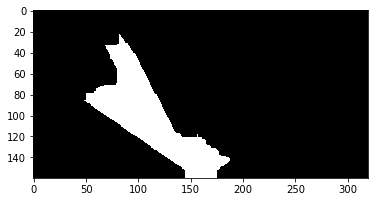

In [6]:
# applying closing on navigable terrain to eleminate noise
kernel = np.ones((15,15))
nav_threshed = cv2.morphologyEx(nav_threshed, cv2.MORPH_CLOSE, kernel)
plt.imshow(nav_threshed, cmap='gray')

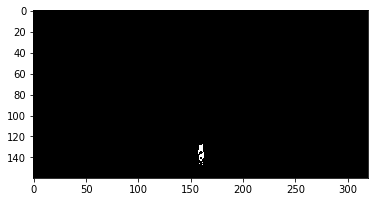

In [7]:
# finding rocks pixels
min_rocks_rgb_thresh = (142,116,0)
max_rocks_rgb_thresh = (209,180,100)
rock_threshed = color_thresh(warped,min_rocks_rgb_thresh,max_rocks_rgb_thresh)
plt.imshow(rock_threshed, cmap='gray')

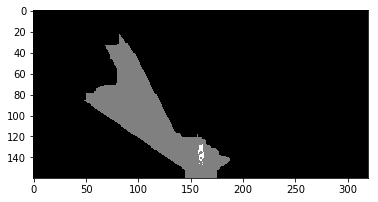

In [8]:
# adding rocks and navigabel terrain together 
rock_nav_threhed = nav_threshed + rock_threshed
plt.imshow(rock_nav_threhed, cmap='gray')

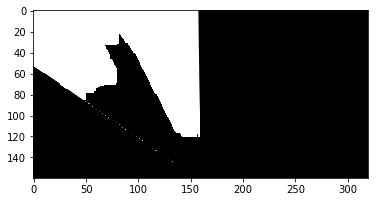

In [9]:
obs = np.absolute(nav_threshed - 1) * mask
plt.imshow(obs, cmap='gray')

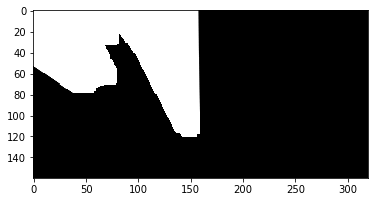

In [10]:
#applying opening on obstacle to eleminate noise using same kernal
obs = cv2.morphologyEx(obs, cv2.MORPH_OPEN, kernel)
plt.imshow(obs, cmap='gray')

# Adjust to world Coordinates

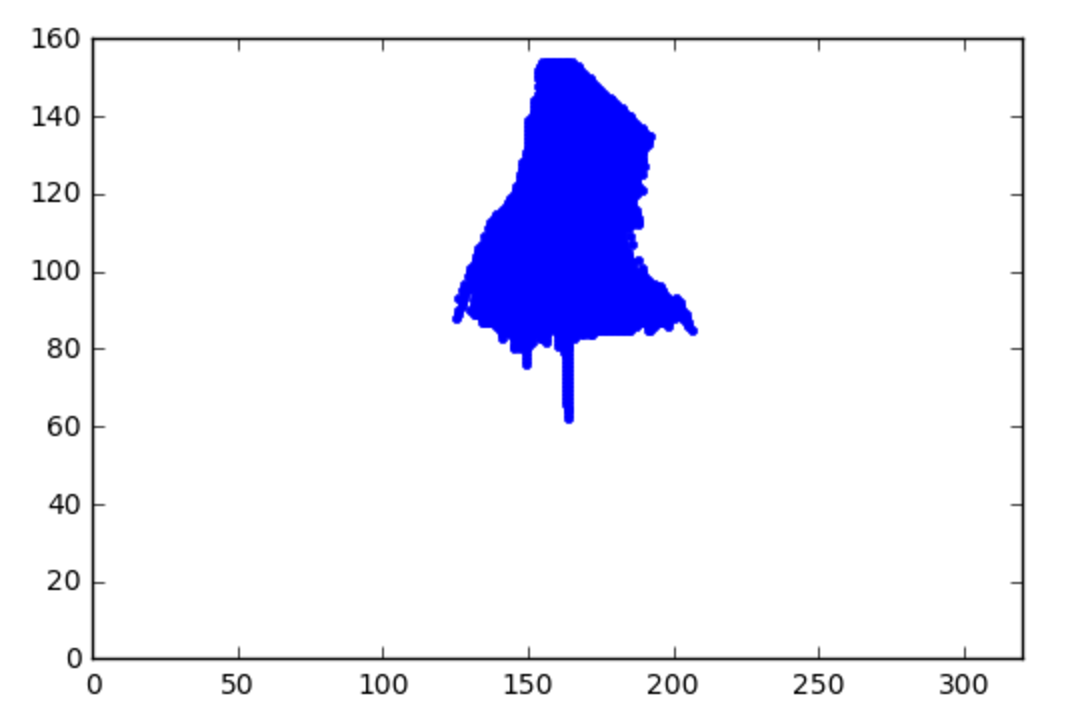

## World Map

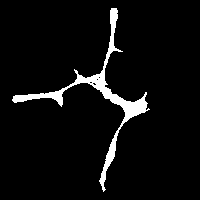

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

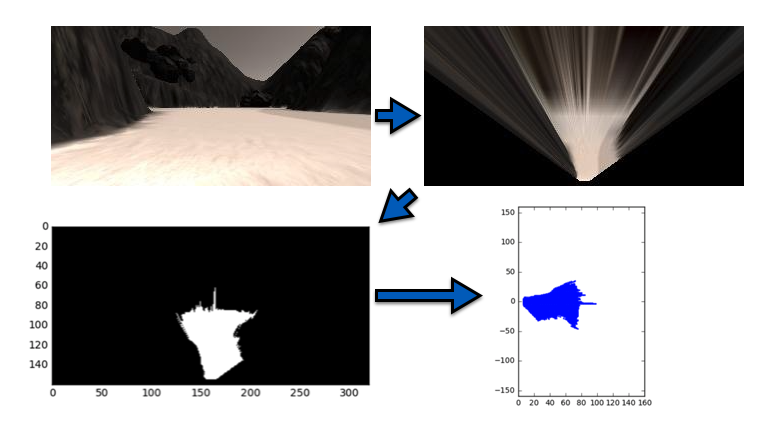

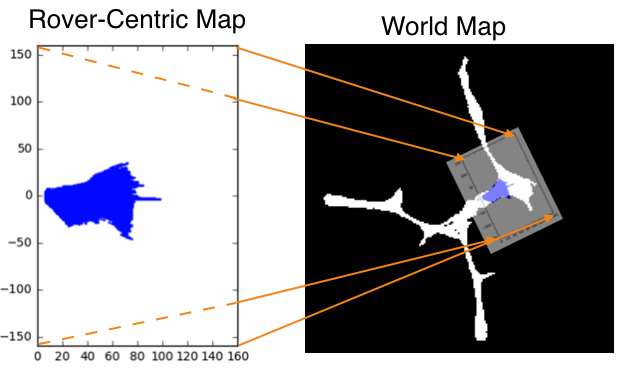

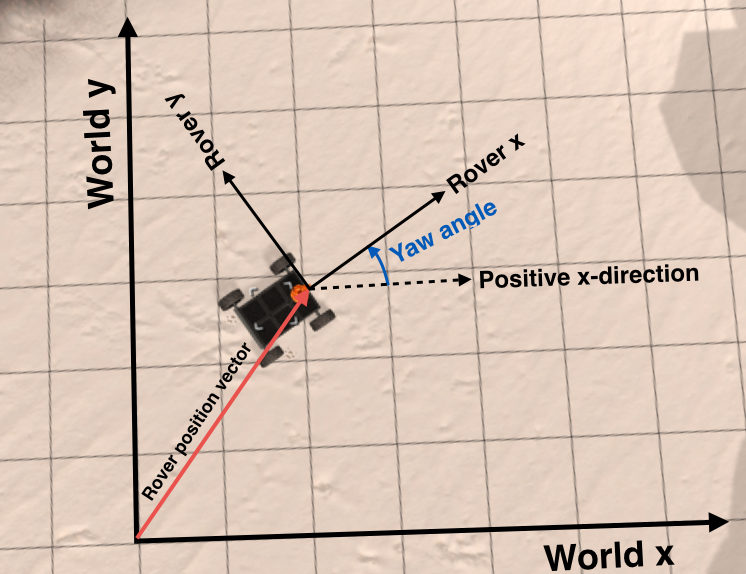

In [11]:
df = pd.read_csv("test_dataset/robot_log.csv",sep=';')
df['Path'] = df['Path'].str.slice(start=3)
df.head()

,Path,SteerAngle,Throttle,Brake,Speed,X_Position,Y_Position,Pitch,Yaw,Roll
0,test_dataset/IMG/robocam_2017_05_02_11_16_21_4...,0.0,0.0,1.0,0.0,99.66999,85.58897,0.000236,56.82555,2.093137e-07
1,test_dataset/IMG/robocam_2017_05_02_11_16_21_4...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82555,2.299884e-07
2,test_dataset/IMG/robocam_2017_05_02_11_16_21_4...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82555,2.299884e-07
3,test_dataset/IMG/robocam_2017_05_02_11_16_21_5...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82555,2.299884e-07
4,test_dataset/IMG/robocam_2017_05_02_11_16_21_6...,0.0,0.0,0.0,0.0,99.66999,85.58897,0.000236,56.82555,2.299884e-07


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 10 columns):
Path          283 non-null object
SteerAngle    283 non-null float64
Throttle      283 non-null float64
Brake         283 non-null float64
Speed         283 non-null float64
X_Position    283 non-null float64
Y_Position    283 non-null float64
Pitch         283 non-null float64
Yaw           283 non-null float64
Roll          283 non-null float64
dtypes: float64(9), object(1)
memory usage: 22.2+ KB


In [13]:
world_map = "calibration_images/map_bw.png"
world_map_img = mpimg.imread(world_map)
world_map_img.shape

(200, 200)

In [212]:
# plots arrow given angle, and color
def plot_arrow(dirc,color='red'):
    x_arrow = arrow_length * np.cos(dirc)
    y_arrow = arrow_length * np.sin(dirc)
    plt.arrow(0, 0, x_arrow, y_arrow, color=color, zorder=2, head_width=10, width=2)

In [213]:
# duplicate angle based on how close it is to origin (gives more weight to close angles than far ones)
def dulpicate(angles, dist):
    dist_max = dist.max()
    dist_min = dist.min()
    dup_angles = []    
    for i in range(len(dist)):
        dup = int((dist_max-dist[i])/(dist_max-dist_min) * 10)
        for j in range(dup):
            dup_angles.append(angles[i])
    return np.array(dup_angles)



In [225]:
"""
Calculate steering angle based on navigable angles and distances and obstacle angles 

1) duplicates  navigable  angles to give more weight to close angles
2) calculate first quartile, third quartile, and mean of navigable angles
3) compare each value with the obstacle angles and see if it is included
4) return the direction that isn't included in obstacle angles 
5) if all directions are inside obstacle return 1000
"""

def calc_dir_old(dist,angles,obj_angles,previous_dir):
    dup_angles = dulpicate(angles,dist)
    first_quartile_dir = np.quantile(dup_angles,0.25)
    mean_dir = np.mean(dup_angles)
    third_quartile_dir = np.quantile(dup_angles,0.75)
    first_quartile_dir_r = first_quartile_dir.round(2)
    mean_dir_r = mean_dir.round(2)
    third_quartile_dir_r = third_quartile_dir.round(2)
    obj_angles = obj_angles.round(2)
    dir_list = [first_quartile_dir_r,mean_dir_r,third_quartile_dir_r]
    crash_dir = []
    for dirc in dir_list:
        crash_dir.append(len(obj_angles[obj_angles==dirc])>0)
    # if first quartile doesn't crash but third quartile crash return first quartile
    if crash_dir[0] == False and crash_dir[2] == True : return first_quartile_dir
    # if third quartile doesn't crash but first quartile crash return third quartile
    elif crash_dir[0] == True and crash_dir[2] == False : return third_quartile_dir
    # if mean direction doesn't crash return mean direction
    elif crash_dir[1] == False : return mean_dir
    # if both first and third quartile doesn't crash but mean crashes 
    # return the one that is nearest to the previous direction 
    elif crash_dir[0] == False and crash_dir[2] == False : 
        return third_quartile_dir if (abs(first_quartile_dir - previous_dir) > abs(third_quartile_dir - previous_dir)) else first_quartile_dir
    # if all directions crash return 1000 as a flag to indicate a crash is incoming regardless of direction
    return 1000

In [238]:
"""
Calculate steering angle based on navigable angles and distances and obstacle angles 

1) duplicates  navigable  angles to give more weight to close angles
2) calculate first quartile, third quartile, and mean of navigable angles
3) compare each value with the obstacle angles and see if it is included
4) return the direction that isn't included in obstacle angles 
5) if all directions are inside obstacle return 1000
"""

def calc_dir(dist,angles):
    angles = angles.round(2)
    dup_angles = dulpicate(angles,dist)
    first_quartile_dir = np.quantile(dup_angles,0.3)
    median_dir = np.quantile(dup_angles,0.5)
    third_quartile_dir = np.quantile(dup_angles,0.7)
    first_quartile_dir_r = first_quartile_dir.round(2)
    mean_dir_r = median_dir.round(2)
    third_quartile_dir_r = third_quartile_dir.round(2)
    dir_list = [first_quartile_dir_r,mean_dir_r,third_quartile_dir_r]
    max_dist_dir = []
    for dirc in dir_list:
        max_dist_indices = np.where(angles==dirc)
        #print(max_dist_indices)
        max_dist = dist[max_dist_indices].max()
        max_dist_dir.append(max_dist)
    max_dist_dir = np.array(max_dist_dir)
    best_dir_index =   np.where(max_dist_dir == max_dist_dir.max())
    return dir_list[best_dir_index[0][0]]

-1.4464413 1.1071488
-0.47646740078926086 -0.42
-2.9411972681471585
-82.87498 63.434948
-27.299571140792917 -24.064227395494573
-2.9411971776109986


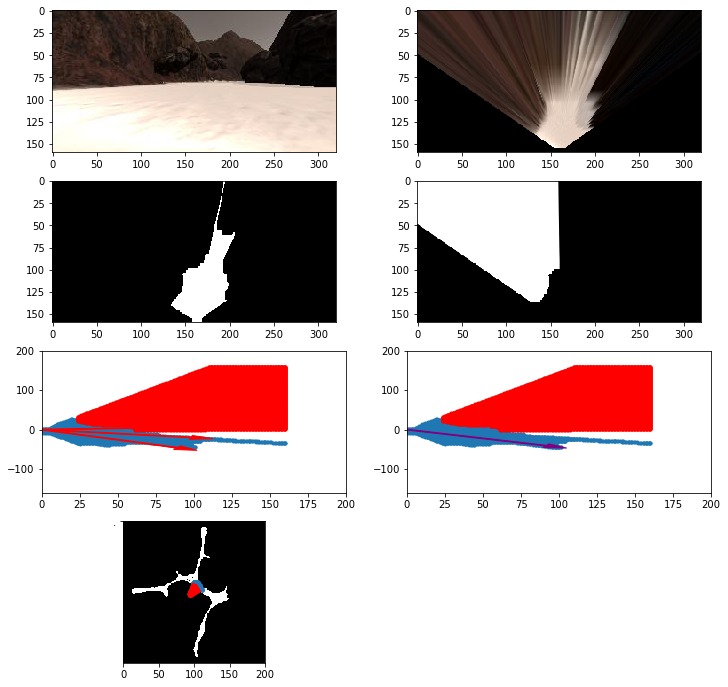

In [290]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float32)
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot/scale) + xpos
    ypix_translated = (ypix_rot/scale) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
   # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world


    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
idx = 160
image = mpimg.imread(img_list[idx])
image_info = df[df["Path"]==img_list[idx]]
image_info = image_info.squeeze()
dst = 5
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])

warped, mask = perspect_transform(image, source, destination)
nav_threshed = color_thresh(warped)
kernel = np.ones((10,10))
nav_threshed = cv2.morphologyEx(nav_threshed, cv2.MORPH_CLOSE, kernel)
obstacle = np.absolute(nav_threshed - 1) * mask
obstacle = cv2.morphologyEx(obstacle, cv2.MORPH_OPEN, kernel)
xpos = image_info['X_Position']
ypos = image_info['Y_Position']
yaw = image_info['Yaw']
world_size = 200
scale =  2 * dst
# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(nav_threshed)
xpix_obs, ypix_obs = rover_coords(obstacle)
dist, angles = to_polar_coords(xpix, ypix)
obj_dist, obj_angles = to_polar_coords(xpix_obs, ypix_obs)
# calculating steering angle based on obstacle and navigable angles and distance

dup_angles = dulpicate(angles,dist)
dup_obj_angles = dulpicate(obj_angles,obj_dist)
first_quartile_dir = np.quantile(dup_angles,0.25)
mean_dir = np.mean(dup_angles)
third_quartile_dir = np.quantile(dup_angles,0.75)
dirc_old = calc_dir_old(dist,angles,obj_angles,0) 
dirc = calc_dir(dist,angles)

#mean_dir = np.mean(angles)

x_nav_world, y_nav_world = pix_to_world(xpix, ypix,xpos, ypos, yaw, world_size, scale)
x_obs_world, y_obs_world = pix_to_world(xpix_obs, ypix_obs,xpos, ypos, yaw, world_size, scale)
    #x_obs_world, y_obs_world = pix_to_world(xpix_obs, ypix_obs,xpos, ypos, yaw, world_size, scale)
# Do some plotting
fig = plt.figure(figsize=(12,12))
plt.subplot(421)
plt.imshow(image)
plt.subplot(422)
plt.imshow(warped)
plt.subplot(423)
plt.imshow(nav_threshed, cmap='gray')
plt.subplot(424)
plt.imshow(obstacle, cmap='gray')
plt.subplot(425)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 200)
plt.xlim(0, 200)
arrow_length = 100
plot_arrow(first_quartile_dir)
plot_arrow(mean_dir)
plot_arrow(third_quartile_dir)
plt.plot(xpix_obs, ypix_obs, '.',color="red")
plt.subplot(426)
plt.plot(xpix, ypix, '.')
plt.plot(xpix_obs, ypix_obs, '.',color="red")
plt.ylim(-160, 200)
plt.xlim(0, 200)
arrow_length = 100
plot_arrow(dirc,'purple')
plt.subplot(427)
plt.imshow(world_map_img,cmap='gray')
plt.plot(x_nav_world, y_nav_world, '.')
plt.plot(x_obs_world, y_obs_world,'r', '.')
print(angles.min(),angles.max())
print(dirc_old ,dirc)
steering_angle = 30 * (dirc-angles.min())/(angles.max()-angles.min()) -15
print(steering_angle)
angles = angles * 180/np.pi
print(angles.min(),angles.max())
print(dirc_old * 180/np.pi,dirc * 180/np.pi)
steering_angle = 30 * (dirc* 180/np.pi-angles.min())/(angles.max()-angles.min()) -15
print(steering_angle)

In [291]:
print(obj_dist.min()/dst,obj_dist.max()/dst)

6.511528015136719 45.254833984375


In [263]:
print(angles.min(),angles.max())
print(dirc_old ,dirc)
steering_angle = 30 * (dirc-angles.min())/(angles.max()-angles.min()) -15
print(steering_angle)
angles = angles * 180/np.pi
print(angles.min(),angles.max())
print(dirc_old * 180/np.pi,dirc * 180/np.pi)
steering_angle = 30 * (dirc* 180/np.pi-angles.min())/(angles.max()-angles.min()) -15
print(steering_angle)

-1.4940244 1.4288993
-0.2610442 -0.6
-5.82400504746065
-85.60129 81.869896
-14.956731169020998 -34.37746770784939
-5.824006259735281


In [248]:
angles = angles * 180/np.pi
print(angles.min(),angles.max())

In [199]:
angles = angles.round(2)

In [211]:
angles = angles.round(2)
dup_angles = dulpicate(angles,dist)
first_quartile_dir = np.quantile(dup_angles,0.25)
median_dir = np.quantile(dup_angles,0.5)
third_quartile_dir = np.quantile(dup_angles,0.75)
first_quartile_dir_r = first_quartile_dir.round(2)
mean_dir_r = mean_dir.round(2)
third_quartile_dir_r = third_quartile_dir.round(2)
dir_list = [first_quartile_dir_r,mean_dir_r,third_quartile_dir_r]
max_dist_dir = []
for dirc in dir_list:
    max_dist_indices = np.where(angles==dirc)
    #print(max_dist_indices)
    max_dist = dist[max_dist_indices].max()
    max_dist_dir.append(max_dist)
max_dist_dir = np.array(max_dist_dir)
return best_dir_index = np.where(max_dist_dir == max_dist_dir.max())
print(dir_list[best_dir_index[0][0]],dir_list,max_dist_dir)

-0.84 [-0.84, -0.53, -0.31] [199.64969 102.21546  88.23265]


In [102]:
def calc_dir(dist,angles,obj_dist,obj_angles):
    dup_angles = dulpicate(angles,dist)
    dup_obj_angles = dulpicate(obj_angles,obj_dist)
    first_quartile_dir = np.quantile(dup_angles,0.25)
    mean_dir = np.mean(dup_angles)
    third_quartile_dir = np.quantile(dup_angles,0.75)
    first_quartile_dir_r = first_quartile_dir.round(2)
    mean_dir_r = mean_dir.round(2)
    third_quartile_dir_r = third_quartile_dir.round(2)
    obj_angles = obj_angles.round(2)
    dir_list = [first_quartile_dir_r,mean_dir_r,third_quartile_dir_r]
    crash_dir = []
    for dirc in dir_list:
        crash_dir.append(len(obj_angles[obj_angles==dirc])>0)
    if crash_dir[0] == False and crash_dir[2] == True : return first_quartile_dir
    elif crash_dir[0] == True and crash_dir[2] == False : return third_quartile_dir
    elif crash_dir[0] == False and crash_dir[2] == False and crash_dir[1] == True : return mean_dir
    else: return -1

In [98]:
dist, angles = to_polar_coords(xpix, ypix)
dup_angles = dulpicate(angles,dist)
obj_dist, obj_angles = to_polar_coords(xpix_obs, ypix_obs)
dup_obj_angles = dulpicate(obj_angles,obj_dist)
first_quartile_dir = np.quantile(dup_angles,0.25)
mean_dir = np.mean(dup_angles)
third_quartile_dir = np.quantile(dup_angles,0.75)
first_quartile_dir = first_quartile_dir.round(2)
mean_dir = mean_dir.round(2)
third_quartile_dir = third_quartile_dir.round(2)

In [97]:
first_quartile_dir

-0.54

In [103]:
calc_dir(dist,angles,obj_dist,obj_angles)

-0.544280469417572

In [96]:
obj_angles = obj_angles.round(2)
dir_list = [first_quartile_dir,mean_dir,third_quartile_dir]
crash_dir = []
for dirc in dir_list:
    crash_dir.append(len(obj_angles[obj_angles==dirc])>0)
crash_dir

[False, False, True]

In [94]:
print(mean_dup,mean_dir,first_quartile_dir)

NameError: name 'mean_dup' is not defined

In [ ]:
mean_dup = np.mean(dup_angles)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 200)
plt.xlim(0, 200)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dup)
y_arrow = arrow_length * np.sin(mean_dup)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [ ]:
dup_angles = dulpicate(angles,dist)
fig = plt.figure(figsize=(10,7))
plt.subplot(121)
plt.hist(angles)
plt.subplot(122)
plt.hist(dup_angles)

In [ ]:
first_quartile_dir

In [ ]:
first_quartile_dir = np.quantile(dup_angles,0.75)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 200)
plt.xlim(0, 200)
arrow_length = 100
x_arrow = arrow_length * np.cos(first_quartile_dir)
y_arrow = arrow_length * np.sin(first_quartile_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [ ]:
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 200)
plt.xlim(0, 200)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [ ]:
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(world_map_img,cmap='gray')
plt.plot(x_nav_world, y_nav_world, '.')
plt.plot(x_obs_world, y_obs_world,'r', '.')
plt.subplot(223)
plt.imshow(obstacle, cmap='gray')
plt.subplot(224)
plt.imshow(mask, cmap='gray')

In [303]:
np.array([]).min()

ValueError: zero-size array to reduction operation minimum which has no identity